In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

%matplotlib inline

#exploring instability with sinusoidal perturbations

$$\dot \theta_j = \omega_0 - \frac{K}{2} \left[ {\rm tanh} \left( \frac{ \cos\theta_{j-1} - \cos\theta_{j} - \beta}{h_{ol}} \right) + 1\right]  $$ 
$$ - \nu \left[ \sin( \theta_j- \theta_{j+1}) + \sin(\theta_j - \theta_{j-1}) \right]$$
$$ + \nu_c \left[ \cos( \theta_j- \theta_{j+1}) + \cos(\theta_j- \theta_{j-1}) \right]$$
$$ + A_c \cos(\theta_j + \theta_{j+1}) + A_s \sin(\theta_j + \theta_{j+1}) 
+ A_c \cos(\theta_j + \theta_{j-1}) + A_s \sin(\theta_j + \theta_{j-1})$$

The local Kuramoto model is $K_s = A_c = A_s = 0$ and $\nu >0$. 
The simple Niedermayer model has $\nu>0$ and   $\nu_c>0$.

Sign or order of inside of $\nu_c$ cosine terms is irrelevant! 


This model encompases a vanilla phase oscillator model along with one sided overlap term and some terms
that involve sums of angles


$$ \cos(\theta_j + \theta_{j+1}  ) + \cos (\theta_j + \theta_{j-1})  = 2 \cos (( 2\theta_j + \theta_{j+1} + \theta_{j-1})/2) \cos((\theta_{j+1} - \theta_{j+1})/2) $$ 
$$ \sin(\theta_j + \theta_{j+1}  ) + \sin (\theta_j + \theta_{j-1})  = 
2 \sin (( 2\theta_j + \theta_{j+1} + \theta_{j-1})/2) \cos((\theta_{j+1} - \theta_{j+1})/2) $$

In [51]:
# functions for phase oscillator models 
# up is theta_j+1
# um is theta_j-1
# uj is theta_j

# function used to find dudt
def du_fun_overlap(up,uj,um,parms):
    omega0=parms[0]
    K = parms[1]
    nu = parms[2]
    nu_c = parms[3]
    beta = parms[4]
    hor = parms[5]
    hol = hor
    A_c = parms[6]
    A_s = parms[7]
    #overlap_right = np.cos(uj) - np.cos(up) - beta
    #tor = K*0.5*(np.tanh(overlap_right/hor) + 1.)
    #du_j = omega0 - tor;
    overlap_left  = np.cos(um) - np.cos(uj) - beta
    tol = K*0.5*(np.tanh(overlap_left/hol) + 1.)
    du_j = omega0 - tol;
    du_j += nu*(np.sin(up -uj)+ np.sin(um-uj))  # some diffusion if you want it
    du_j += nu_c*(np.cos(up -uj)+ np.cos(um-uj))  
    du_j += A_c*np.cos(uj + up) + A_s*np.sin(uj + up)  # neidermayer like terms
    du_j += A_c*np.cos(uj + um) + A_s*np.sin(uj + um)
    return du_j

# compute dudt
def du(func,u_arr,parms):
    up = np.copy(np.roll(u_arr,-1))  #periodic bc
    um = np.copy(np.roll(u_arr,1))
    uj = np.copy(u_arr)
    du_arr = func(up,uj,um,parms)
    return du_arr


isang = 1 # if u is an angle or not
twopi = 2*np.pi
#np.random.seed(2)

# do a time step on the theta array
def update_onestep(func,u_arr,parms,dt):
    dudt = du(func,u_arr,parms)
    u_arr = u_arr + dudt*dt
    # do the white noise here
    # u_arr += np.sqrt(eta*dt)*np.random.normal(size=N)
    if (isang==1):
        u_arr = np.mod(u_arr,twopi)
    return u_arr


# take one step using 4th order Runge-kutta
# https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods
# do a time step on the theta array
def update_onestep_rk4(func,u_arr,parms,dt):
    k1 = du(func,u_arr          ,parms)
    k2 = du(func,u_arr + dt*k1/2,parms)
    k3 = du(func,u_arr + dt*k2/2,parms)
    k4 = du(func,u_arr + dt*k3  ,parms)
    yn1 = u_arr + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0
    #u_arr = u_arr + dudt*dt
    u_arr = yn1
    # do white noise here
    # u_arr += np.sqrt(eta*dt)*np.random.normal(size=N)
    if (isang==1):
        u_arr = np.mod(u_arr,twopi)
    return u_arr


# do nsteps time steps on the theta array
def update_nsteps(func,u_arr,parms,dt,nsteps):
    for i in range(nsteps):
        u_arr = update_onestep_rk4(func,u_arr,parms,dt)
    return u_arr

In [3]:
# different types of initial conditions
# iparms determine parmeters for initial conditions 
def give_init(N,iparms):
    eta_rand   =iparms[0]  # random uniform 
    slope_ramp =iparms[1]  # slope of a ramp
    mag_sin    =iparms[2]  # mag of a sine perturbation, 
    index_sin  =iparms[3]  # sets wavelength of sine
    phase_sin = iparms[4]  # set phase 
    peak       =iparms[5]  # make one point this value, choose point randomly
    iroll_ramp  =int(iparms[6])  # shift of the ramp, allows you to set step discontinuity location
    #npeaks     =iparms[5]  # if >1 then randomly choose npeaks positions to give a peak value
    u_arr = np.zeros(N)  #allocate, zero initial conditions 
    u_arr += eta_rand*np.random.random(size=N)  # random everywhere, uniform distn
    irr = int(np.random.random()*N)  # one randomly chosen location has value peak
    u_arr[irr] = peak 
    phi = np.random.random()*2*np.pi # randomly chosen phase
    for i in range(N): # sinusoidal
        #u_arr[i] += mag_sin*np.sin(2*np.pi*i*index_sin/N + phi)  # index_sin sets wavelength
        u_arr[i] += mag_sin*np.sin(2*np.pi*i*index_sin/N + phase_sin)  # index_sin sets wavelength
    ii = np.arange(N)
    ramp = (2*np.pi*slope_ramp*ii/N)
    ramp = np.roll(ramp,iroll_ramp)
    u_arr += ramp # ramp

    return u_arr%(2*np.pi)  # keep within [0,2pi]


In [4]:
# compute phase difference
# as defined in Denes+21
# phi_i = theta_i - theta_i-1 - 2 pi floor( (theta_i - theta_i-1 + pi) /2pi) 
# should return numbers between [-pi,pi]
# also returns the cummulative sum of the phase shifts
def phase_shift(u_arr):
    uj = np.copy(u_arr)
    um = np.roll(uj,1)
    fac = (uj - um + np.pi)/(2*np.pi)
    phi_j = uj - um - 2*np.pi*np.floor(fac)
    csum = np.cumsum(phi_j) # cummulative sum of the phase differences 
    return phi_j,csum
    

In [77]:
# show an integration and 2 different timesteps, do integration
def plt2(func,u_arr0,parms,dt,nsteps,dn):
    u_arr1 = update_nsteps(func,u_arr0,parms,dt,nsteps)
    u_arr2 = update_nsteps(func,u_arr1,parms,dt,dn)
   
    fig,ax = plt.subplots(1,1,figsize=(9,4),dpi=100)
    ax.plot(u_arr1,'ro')
    ax.plot(u_arr2,'bo')
    print('t={:.0f}'.format(dt*nsteps))
    
    
# show an integration and nn different timesteps separation dn
colorlist = ['red','orange','gold','green','dodgerblue','blue','magenta','violet','brown']
ncolorlist = len(colorlist)
def pltn(func,u_arr0,parms,dt,dn,nn):
    fig,ax = plt.subplots(1,1,figsize=(9,4),dpi=100)
    u_arr = np.copy(u_arr0)
    for k in range(nn):
        u_arr = update_nsteps(func,u_arr,parms,dt,dn)
        ax.plot(u_arr,'o',color=colorlist[k%ncolorlist])
        print('t={:.0f}'.format(dt*dn*(k+1)))
        

    
# do integration
# fill an image with array outputs of uarr at different times
# start with nsteps, separation between outs is dn (in steps)
# and have ndn rows
# returns 2d arrays
# first one is nsteps*dt
# remaining separations are dn*dt
# number of outputs is ndn
# returns:
#  uarr arrays
#  dudt arrays
#  phase differences (as in Denes) arrays
#  winding number array for the output timestep
def mkphaseprofile(func,N,parms,dt,nsteps,dn,ndn,iparms):
    u_arr0 = give_init(N,iparms)  # get initial conditions
    ndt=0;
    nsteps_pass=nsteps  # number of steps to first one
    uout_arr = np.zeros((ndn,N))
    dudt_arr = np.zeros((ndn,N))
    dudj_arr = np.zeros((ndn,N))
    csum_arr = np.zeros((ndn,N))
    u_arr = update_nsteps(func,u_arr0,parms,dt,nsteps_pass) # integrate
    du_arr = du(func,u_arr,parms)
    phi_j,csum = phase_shift(u_arr) 
    du_dj = phi_j
    #du_dj = (np.roll(u_arr,-1) - u_arr)%twopi # u_j+1-u_j
    #kk = (du_dj > np.pi)
    #du_dj[kk] -= twopi
    uout_arr[0,:] = u_arr
    dudt_arr[0,:] = du_arr
    dudj_arr[0,:] = du_dj
    csum_arr[0,:] = csum
    nsteps_pass = dn #steps per row  # steps per row on subsequent ones
    winding_number = np.zeros(ndn)
    winding_number[0] = np.sum(phi_j)/(2*np.pi)
    for k in range(1,ndn):  #ndn is number of rows
        u_arr = update_nsteps(func,u_arr,parms,dt,nsteps_pass) # integrate
        du_arr = du(func,u_arr,parms)
        phi_j,csum = phase_shift(u_arr)  # compute phase shift as via Denes+11
        #du_dj = (np.roll(u_arr,-1) - u_arr)%twopi
        du_dj = phi_j
        #kk = (du_dj > np.pi)
        #du_dj[kk] -= twopi
        uout_arr[k,:] = u_arr
        dudt_arr[k,:] = du_arr
        dudj_arr[k,:] = du_dj  # is now phase shift
        winding_number[k] = np.sum(phi_j)/(2*np.pi)
        winding_number[k] = csum[-1]/(2*np.pi)
        csum_arr[k,:] = csum
          
    return uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number

# ndn in number of outputs
# dn is number of steps between each output
def pltphase3(uout_arr,dudt_arr,dudj_arr,dt,nsteps,dn,ndn,ofile):
    fig, axarr = plt.subplots(3, 1, figsize=(6, 4), \
                       sharex=True, sharey=True,dpi=300)
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    for k in range(3):
        axarr[k].tick_params(axis='both', which='minor', labelsize=14)
        axarr[k].tick_params(axis='both', which='major', labelsize=14)
    axarr[2].set_yticks([0, 50])
    axarr[2].set_yticklabels(['0', '50'])
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    jarr = np.arange(N+1)
    im0=axarr[0].pcolormesh(tarr,jarr,\
                np.transpose(uout_arr),vmin=0,vmax=twopi,cmap='hsv')
    cbar0=plt.colorbar(im0,ax=axarr[0],fraction=0.04,\
                    ticks=[0, np.pi, 2*np.pi],aspect=5,pad=0.02) 
    cbar0.ax.set_yticklabels(['0', r'$\pi$',r'$2\pi$'])
    cbar0.set_label(r'$\theta$',fontsize=14)
    im1=axarr[1].pcolormesh(tarr,jarr,\
                np.transpose(dudt_arr),vmin=0,vmax=1,cmap='brg')
    cbar1=plt.colorbar(im1,ax=axarr[1],fraction=0.04,\
                    ticks=[0, 0.5, 1],aspect=5,pad=0.02) 
    cbar1.ax.set_yticklabels(['0', '0.5','1'])
    cbar1.set_label(r'd$\theta$/dt',fontsize=14)
    im2=axarr[2].pcolormesh(tarr,jarr,\
                np.transpose(dudj_arr),vmin=-np.pi,vmax=np.pi,cmap='hsv')
    cbar2=plt.colorbar(im2,ax=axarr[2],fraction=0.04,\
                    ticks=[-np.pi,0, np.pi],aspect=5,pad=0.02) 
    cbar2.ax.set_yticklabels([r'$-\pi$', r'$0$',r'$\pi$'])
    cbar2.set_label(r'd$\theta$/dj',fontsize=14)
    axarr[2].set_ylabel('j',fontsize=14)
    axarr[2].set_xlabel('t',fontsize=14)
    if (len(ofile)>3):
        plt.savefig(ofile)


def pltphase4(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ofile):
    fig, axarr = plt.subplots(4, 1, figsize=(6, 4), \
                       sharex=True, sharey=False,dpi=300)
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    for k in range(3):
        axarr[k].tick_params(axis='both', which='minor', labelsize=14)
        axarr[k].tick_params(axis='both', which='major', labelsize=14)
    axarr[2].set_yticks([0, 50])
    axarr[2].set_yticklabels(['0', '50'])
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    jarr = np.arange(N+1)
    im0=axarr[0].pcolormesh(tarr,jarr,\
                np.transpose(uout_arr),vmin=0,vmax=twopi,cmap='hsv')
    cbar0=plt.colorbar(im0,ax=axarr[0],fraction=0.04,\
                    ticks=[0, np.pi, 2*np.pi],aspect=5,pad=0.02) 
    cbar0.ax.set_yticklabels(['0', r'$\pi$',r'$2\pi$'])
    cbar0.set_label(r'$\theta$',fontsize=14)
    im1=axarr[1].pcolormesh(tarr,jarr,\
                np.transpose(dudt_arr),vmin=0,vmax=1,cmap='brg')
    cbar1=plt.colorbar(im1,ax=axarr[1],fraction=0.04,\
                    ticks=[0, 0.5, 1],aspect=5,pad=0.02) 
    cbar1.ax.set_yticklabels(['0', '0.5','1'])
    cbar1.set_label(r'd$\theta$/dt',fontsize=14)
    im2=axarr[2].pcolormesh(tarr,jarr,\
                np.transpose(dudj_arr),vmin=-np.pi,vmax=np.pi,cmap='hsv')
    cbar2=plt.colorbar(im2,ax=axarr[2],fraction=0.04,\
                    ticks=[-np.pi,0, np.pi],aspect=5,pad=0.02) 
    cbar2.ax.set_yticklabels([r'$-\pi$', r'$0$',r'$\pi$'])
    cbar2.set_label(r'd$\theta$/dj',fontsize=14)
    axarr[2].set_ylabel('j',fontsize=14)
    #axarr[2].set_xlabel('t',fontsize=14)
    axarr[3].plot(tarr[0:ndn],winding_number,'.',ms=3)
    axarr[3].set_xlabel('t',fontsize=14)
    cbar3=plt.colorbar(im2,ax=axarr[3],fraction=0.04,\
                    ticks=[-np.pi,0, np.pi],aspect=5,pad=0.02) 
    if (len(ofile)>3):
        plt.savefig(ofile)

        
# plots angle as an image along with winding number 
def newphase2(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ofile):
    fig, axarr = plt.subplots(2, 1, figsize=(6, 4), \
                       sharex=True, sharey=False,dpi=300,facecolor='white')
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    for k in range(2):
        axarr[k].tick_params(axis='both', which='minor', labelsize=14)
        axarr[k].tick_params(axis='both', which='major', labelsize=14)
    #axarr[2].set_yticks([0, 50])
    #axarr[2].set_yticklabels(['0', '50'])
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    jarr = np.arange(N+1)
    im0=axarr[0].pcolormesh(tarr,jarr,\
                np.transpose(uout_arr),vmin=0,vmax=twopi,cmap='hsv')
    rect = 0.81,0.6,0.02,0.37 #l, b, w, h
    ax_cb = fig.add_axes(rect)
    #divider = make_axes_locatable(axarr[0]); 
    #ax_cb = divider.new_horizontal(size="5%", pad=0.05); 
    fig.add_axes(ax_cb)
    cbar0=plt.colorbar(im0,cax=ax_cb,\
                    ticks=[0, np.pi, 2*np.pi],aspect=5,pad=0.02) 
    cbar0.ax.set_yticklabels(['0', r'$\pi$',r'$2\pi$'])
    cbar0.set_label(r'$\theta$',fontsize=14)
    
    #axarr[2].set_xlabel('t',fontsize=14)
    axarr[1].plot(tarr[0:ndn],winding_number,'.',ms=3)
    axarr[1].set_xlabel('t',fontsize=14)
    axarr[1].set_ylabel('winding number',fontsize=14)
    axarr[0].set_ylabel('j',fontsize=14)
    
    if (len(ofile)>3):
        plt.savefig(ofile)
        

# plot theta for a list of outputs
def pltlist(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ilist,ofile):
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3), \
                       sharex=True, sharey=False,dpi=300)
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    for i in range(len(ilist)):
        k = int(ilist[i])
        uarr = np.squeeze(uout_arr[k,:])
        ax.plot(uarr,'o-',color=colorlist[i%ncolorlist],ms=2)
        print('t={:.2f}'.format(tarr[k]))
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=300)
        
        
# plot theta for a list of outputs
def pltlist_mean(uout_arr,dudt_arr,dudj_arr,winding_number,\
                 dt,nsteps,dn,ndn,ilist,offsets,ofile,pos,alabel):
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 2.2), \
                       sharex=True, sharey=False,dpi=300,facecolor='white')
    plt.subplots_adjust(left=0.15, right=0.98,\
                        bottom=0.22,top=0.98,hspace=0)
    for i in range(len(ilist)):
        k = int(ilist[i])
        uarr = np.squeeze(uout_arr[k,:])
        csum = np.sum(np.cos(uarr))
        ssum = np.sum(np.sin(uarr))
        umean = np.arctan2(ssum,csum)
        ushift = (uarr - umean + offsets[i] + np.pi)%(2*np.pi) -np.pi
        ax.plot(ushift,'o',color=colorlist[i%ncolorlist],ms=1,alpha=0.7)
        print('time t={:.2f}'.format(tarr[k]))
        
    ax.set_xlabel('index j',fontsize=14)
    ax.set_ylabel(r'$\theta$ + offset',fontsize=14)
    ax.text(pos[0],pos[1],alabel,fontsize=16)  #label a) or b) or c)
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=300)   
        

def plt_Kfun(parms,uout_arr,ilist):
    
    omega0=parms[0]
    K = parms[1]
    #nu = parms[2]
    beta = parms[3]
    hor = parms[4]
    hol = hor
    #A_c = parms[5]
    #A_s = parms[6]
    ujlin = np.linspace(0,2*np.pi,100)
    umlin = np.linspace(0,2*np.pi,100)
    ujmesh,ummesh = np.meshgrid(ujlin,umlin)
    overlap_left = np.cos(ummesh) - np.cos(ujmesh) - beta
    tol = -K*0.5*(np.tanh(overlap_left/hol) + 1.)
    
    fig,ax = plt.subplots(1,1,figsize=(3.2,2.8),dpi=200,facecolor='white')
    im = ax.pcolormesh(ujmesh,ummesh,tol,cmap='gray')
    ax.set_xlabel(r'$\theta_j$')
    ax.set_ylabel(r'$\theta_{j-1}$')
    plt.colorbar(im)
    
    for i in range(len(ilist)):
        k = int(ilist[i])
        uarr = np.squeeze(uout_arr[k,:])
        umarr = np.roll(np.copy(uarr),1)
        phi,csum = phase_shift(uarr)  # phase diff, as defined by Denes+21
        #plot uj vs uj-1
        ax.plot(uarr,umarr,'.',color=colorlist[i%ncolorlist],ms=2,alpha=0.7) 
            
            
def plt_Kfun2(parms,uout_arr,ilist):
    
    omega0=parms[0]
    K = parms[1]
    #nu = parms[2]
    beta = parms[3]
    hor = parms[4]
    hol = hor
    #A_c = parms[5]
    #A_s = parms[6]
    ujlin = np.linspace(0,2*np.pi,100)
    #umlin = np.linspace(0,2*np.pi,100)
    philin = np.linspace(-np.pi,np.pi,100)
    #philin,junk = phase_shift(ujlin)
    #ujmesh,ummesh = np.meshgrid(ujlin,umlin)
    ujmesh,phimesh = np.meshgrid(ujlin,philin)
    # phi_i = theta_i - theta_i-1 - 2 pi floor( (theta_i - theta_i-1 + pi) /2pi) 
    ummesh = (ujmesh -phimesh)%(2*np.pi)
    
    overlap_left = np.cos(ummesh) - np.cos(ujmesh) - beta
    tol = -K*0.5*(np.tanh(overlap_left/hol) + 1.)
    
    fig,ax = plt.subplots(1,1,figsize=(3.2,2.8),dpi=200,facecolor='white')
    im = ax.pcolormesh(ujmesh,phimesh,tol,cmap='gray')
    ax.set_xlabel(r'$\theta_j$')
    ax.set_ylabel(r'$\phi_j$')
    plt.colorbar(im)
    
    for i in range(len(ilist)):
        k = int(ilist[i])
        uarr = np.squeeze(uout_arr[k,:])
        umarr = np.roll(np.copy(uarr),1)
        phi,csum = phase_shift(uarr)  # phase diff, as defined by Denes+21
        
        # plot uj vs phase shift
        ax.plot(uarr,phi,'.',color=colorlist[i%ncolorlist],ms=2,alpha=0.7)

# plot shift for a list of outputs
def pltlist_phi(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,\
                dn,ndn,ilist,jmin,jmax,ofile):
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3), \
                       sharex=True, sharey=False,dpi=300)
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    ax.set_xlim([jmin,jmax])
    for i in range(len(ilist)):
        k = int(ilist[i])
        uarr = np.squeeze(uout_arr[k,:])
        phi,csum = phase_shift(uarr)
        ax.plot(phi,'o-',color=colorlist[i%ncolorlist],ms=2,lw=0.5)
        print('t={:.2f}'.format(tarr[k]))
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=300)
        

In [83]:

# plots angle as an image along with winding number along with cummulative sum of phase diff
def newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
                ofile,pos,alabel):
    nw=4
    fig, axarr = plt.subplots(nw, 1, figsize=(6, 4), \
                       sharex=True, sharey=False,dpi=300,facecolor='white')
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    for k in range(nw):
        axarr[k].tick_params(axis='both', which='minor', labelsize=14)
        axarr[k].tick_params(axis='both', which='major', labelsize=14)
    
    ytx = axarr[0].yaxis.get_major_ticks()
    #ytx[0].set_visible(False)
    ytx = axarr[1].yaxis.get_major_ticks()
    ytx[-1].set_visible(False)
    ytx[0].set_visible(False)
    
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    jarr = np.arange(N+1)
    
    im0=axarr[0].pcolormesh(tarr,jarr,\
                np.transpose(uout_arr),vmin=0,vmax=twopi,cmap='hsv')
    l, b, w, h = axarr[0].get_position().bounds
    rect0 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb0 = fig.add_axes(rect0)
    fig.add_axes(ax_cb0)
    cbar0=plt.colorbar(im0,cax=ax_cb0,\
                    ticks=[0, np.pi, 2*np.pi],aspect=5,pad=0.02) 
    cbar0.ax.set_yticklabels(['0', r'$\pi$',r'$2\pi$'])
    cbar0.set_label(r'$\theta_j$',fontsize=14)
    
    im1=axarr[1].pcolormesh(tarr,jarr,\
                np.transpose(csum_arr)/(2*np.pi),cmap='rainbow')
    l, b, w, h = axarr[1].get_position().bounds
    rect1 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb1 = fig.add_axes(rect1)
    fig.add_axes(ax_cb1)
    cbar1=plt.colorbar(im1,cax=ax_cb1,\
                    aspect=5,pad=0.02) 
    #cbar1.set_label(r'$\sum_{i=0}^j \phi_i/2\pi$',fontsize=13)
    cbar1.set_label(r'$w_j$',fontsize=14)
    
    im2=axarr[2].pcolormesh(tarr,jarr,np.transpose(dudj_arr),\
                vmin=-np.pi,vmax=np.pi,cmap='coolwarm')
    l, b, w, h = axarr[2].get_position().bounds
    rect2 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb2 = fig.add_axes(rect2)
    fig.add_axes(ax_cb2)
    cbar2=plt.colorbar(im2,cax=ax_cb2,\
                    ticks=[-np.pi,-np.pi/2,0,np.pi/2],aspect=5,pad=0.02) 
    cbar2.ax.set_yticklabels([r'-$\pi$',r'-$\pi$/2','0', r'$\pi$/2'])
    cbar2.set_label(r'$\phi_j$',fontsize=14)
    

    axarr[nw-1].plot(tarr[0:ndn],winding_number,'.',ms=3)
    axarr[nw-1].set_xlabel('time t',fontsize=14)
    axarr[nw-1].set_ylabel('winding w',fontsize=12)
    bottom, top = axarr[nw-1].get_ylim()
    if (np.abs(bottom) + np.abs(top) < 1.5):
        axarr[nw-1].set_ylim([-1.5,1.5])
    for k in range(nw-1):
        axarr[k].set_ylabel('j',fontsize=14)
    
    if (len(ofile)>3):
        axarr[0].text(pos[0],pos[1],alabel,fontsize=16)
        plt.savefig(ofile)
        


(600, 200)

tmax = 601


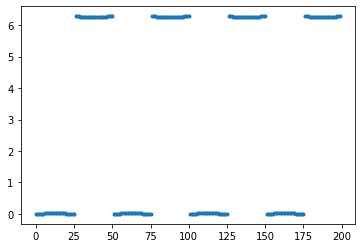

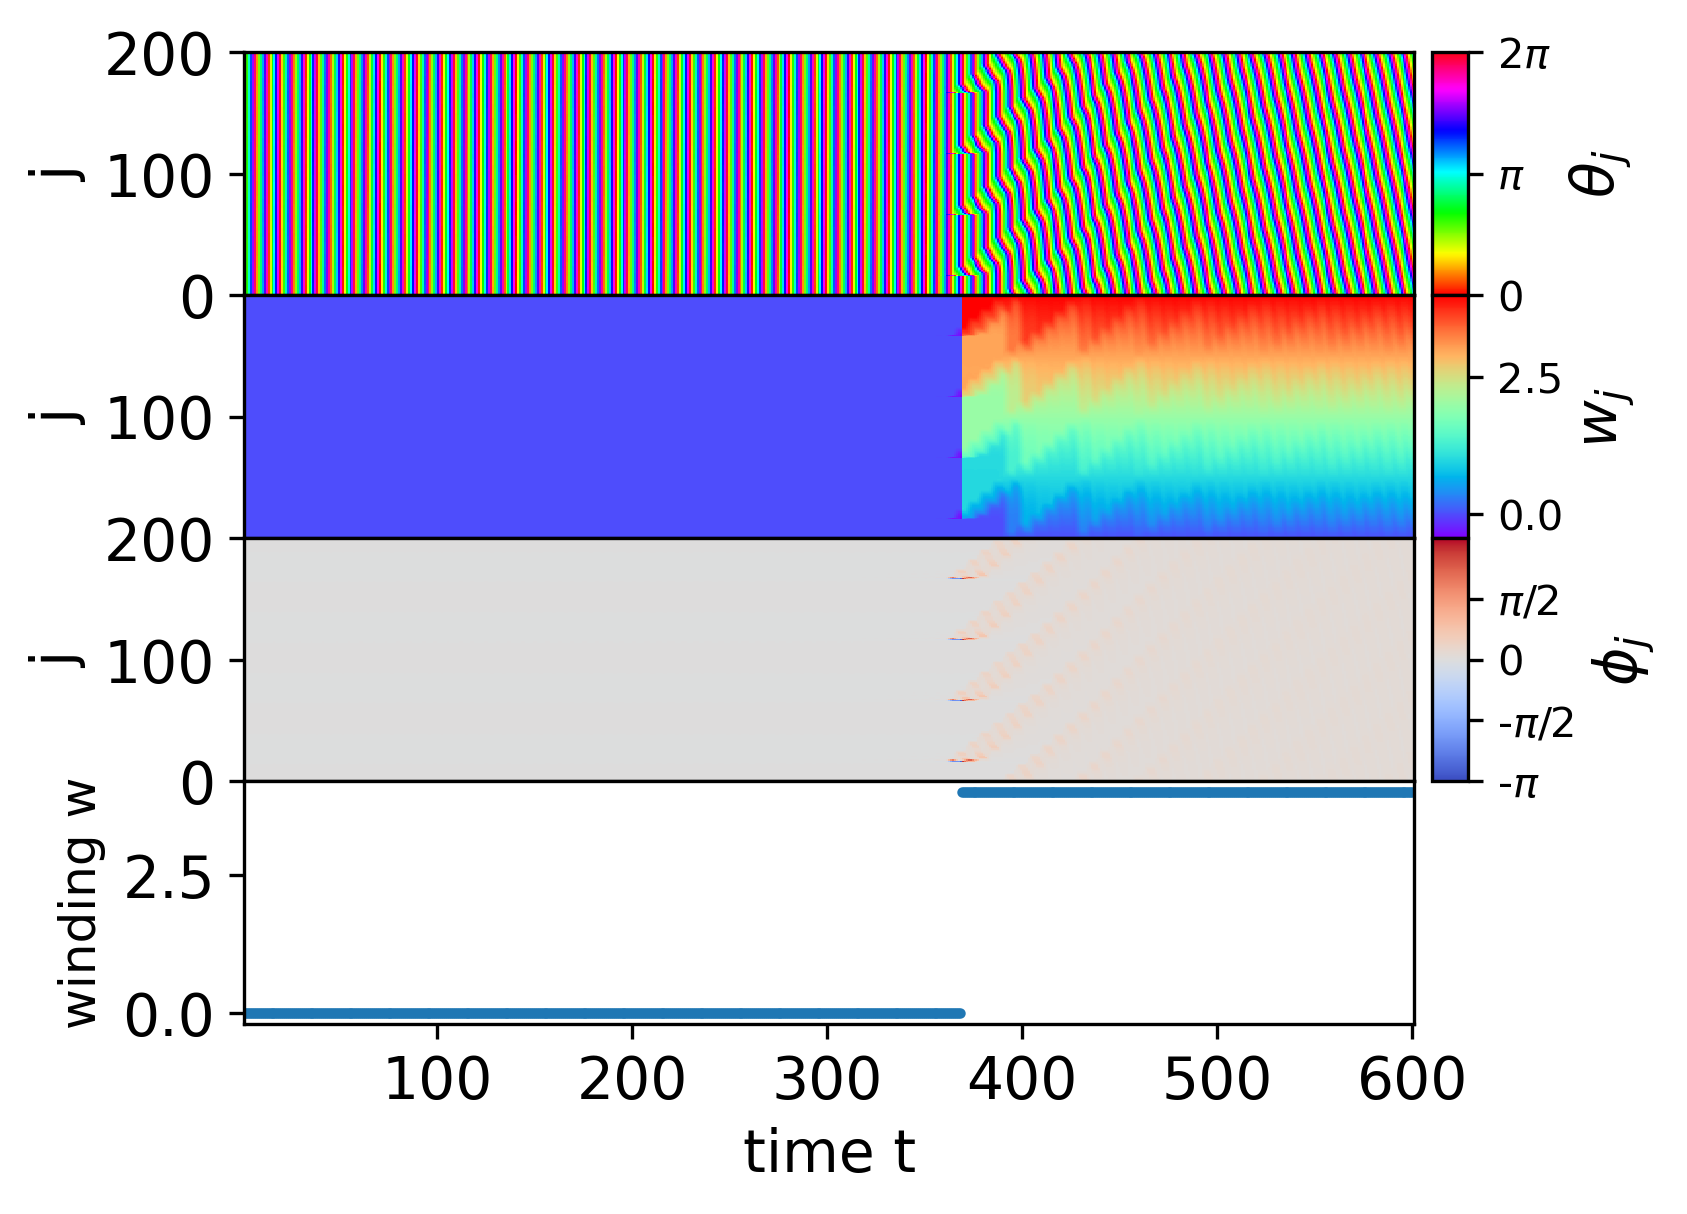

In [66]:
# the one side overlap model 
K=0.7;  hor=0.05; beta=0.1;  A_c = 0.; A_s = 0.; omega0=1.
nu=0.; nu_c = 0.0;
parms = np.zeros(20)
parms[0] = omega0
parms[1] = K
parms[2] = nu
parms[3] = nu_c
parms[4] = beta
parms[5] = hor
parms[6] = A_c
parms[7] = A_s

dt=0.025
func = du_fun_overlap
#nsteps=3000; dn =10;  
#print('t0 = {:.1f}, t1={:.1f}'.format(nsteps*dt, (nsteps+dn)*dt))

# initial conditions 
N=200; eta_rand=0.0; slope_ramp = 0.0; 
mag_sin = 0.02; index_sin = 4;  phase_sin = 0.0;  
peak = 0; iroll_ramp = 10
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])
u_arr0 = give_init(N,iparms)
plt.plot(u_arr0,'.')

# choose initial conditions again?
#N=100; eta_rand=0.1; slope_ramp = -1; mag_sin = 0; index_sin = 1; peak = 0
#iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,peak])
ndn=600; dn=40; nsteps=dn
print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)
#ofile=""
#newphase2(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ofile)
ofile=""; pos=[0,0]; alabel=""
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)

time t=1.00
time t=101.00
time t=201.00
time t=301.00
time t=331.00
time t=341.00
time t=351.00


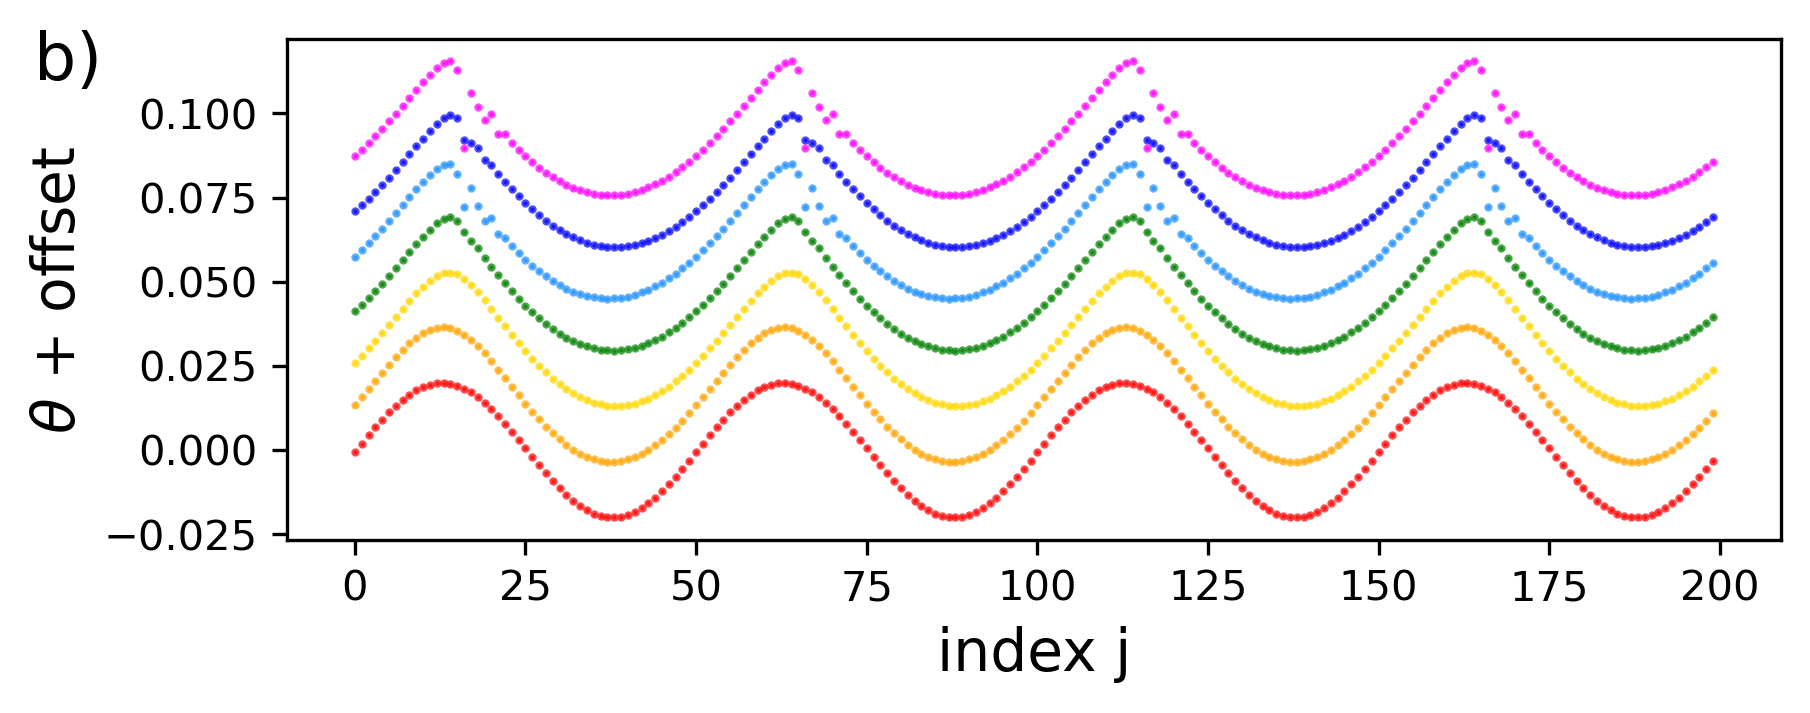

In [78]:
ilist= [0,100,200,300,330,340,350]
offsets = np.zeros(len(ilist))
dz = 0.015
for i in range(len(ilist)):
    offsets[i] = dz*i

ofile = 'sharp_sin_ov2.png'
pos = [-47,0.11]
alabel = 'b)'
pltlist_mean(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,\
             ilist,offsets,ofile,pos,alabel)

t=371.00
t=401.00
t=501.00
t=591.00


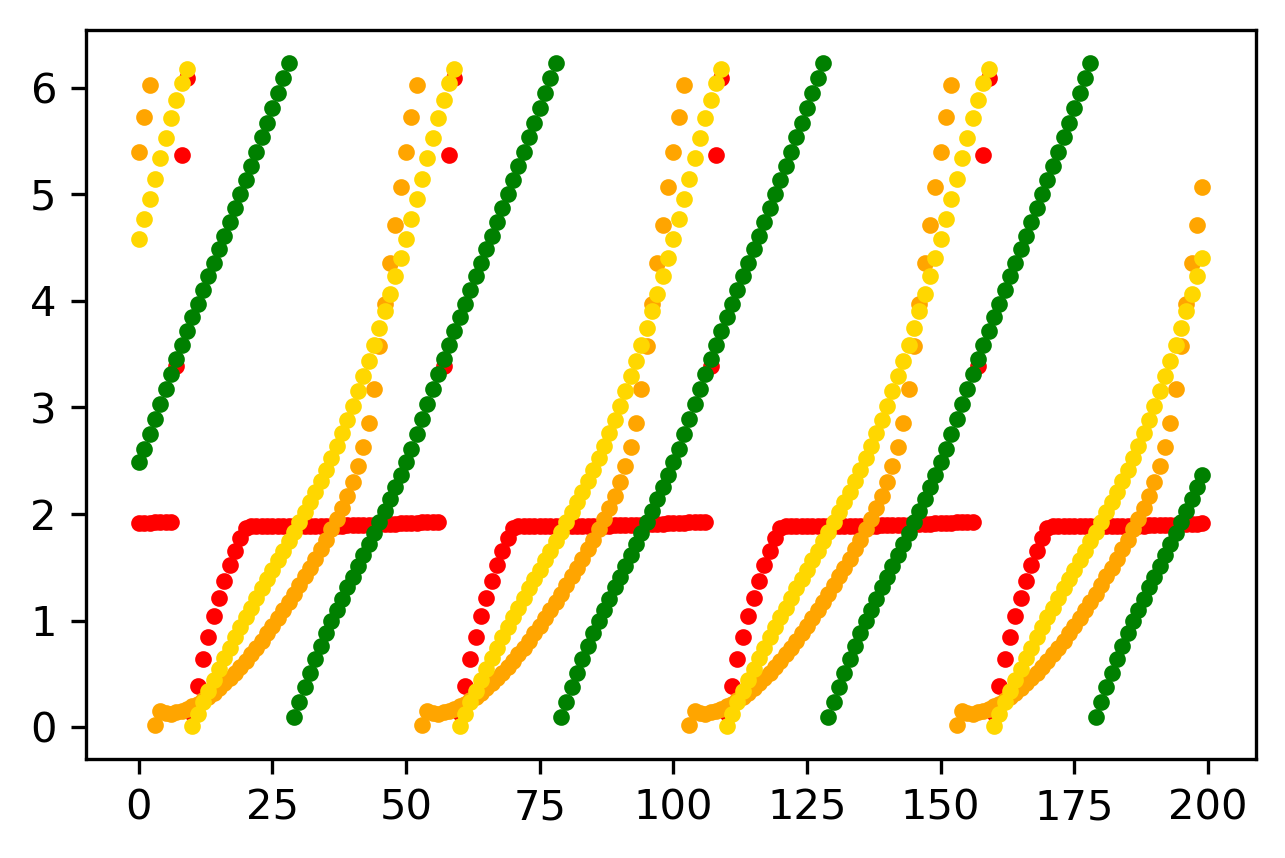

In [324]:
ilist= [370,400,500,590]
pltlist(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ilist,ofile)

tmax = 601


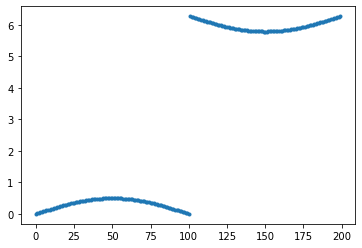

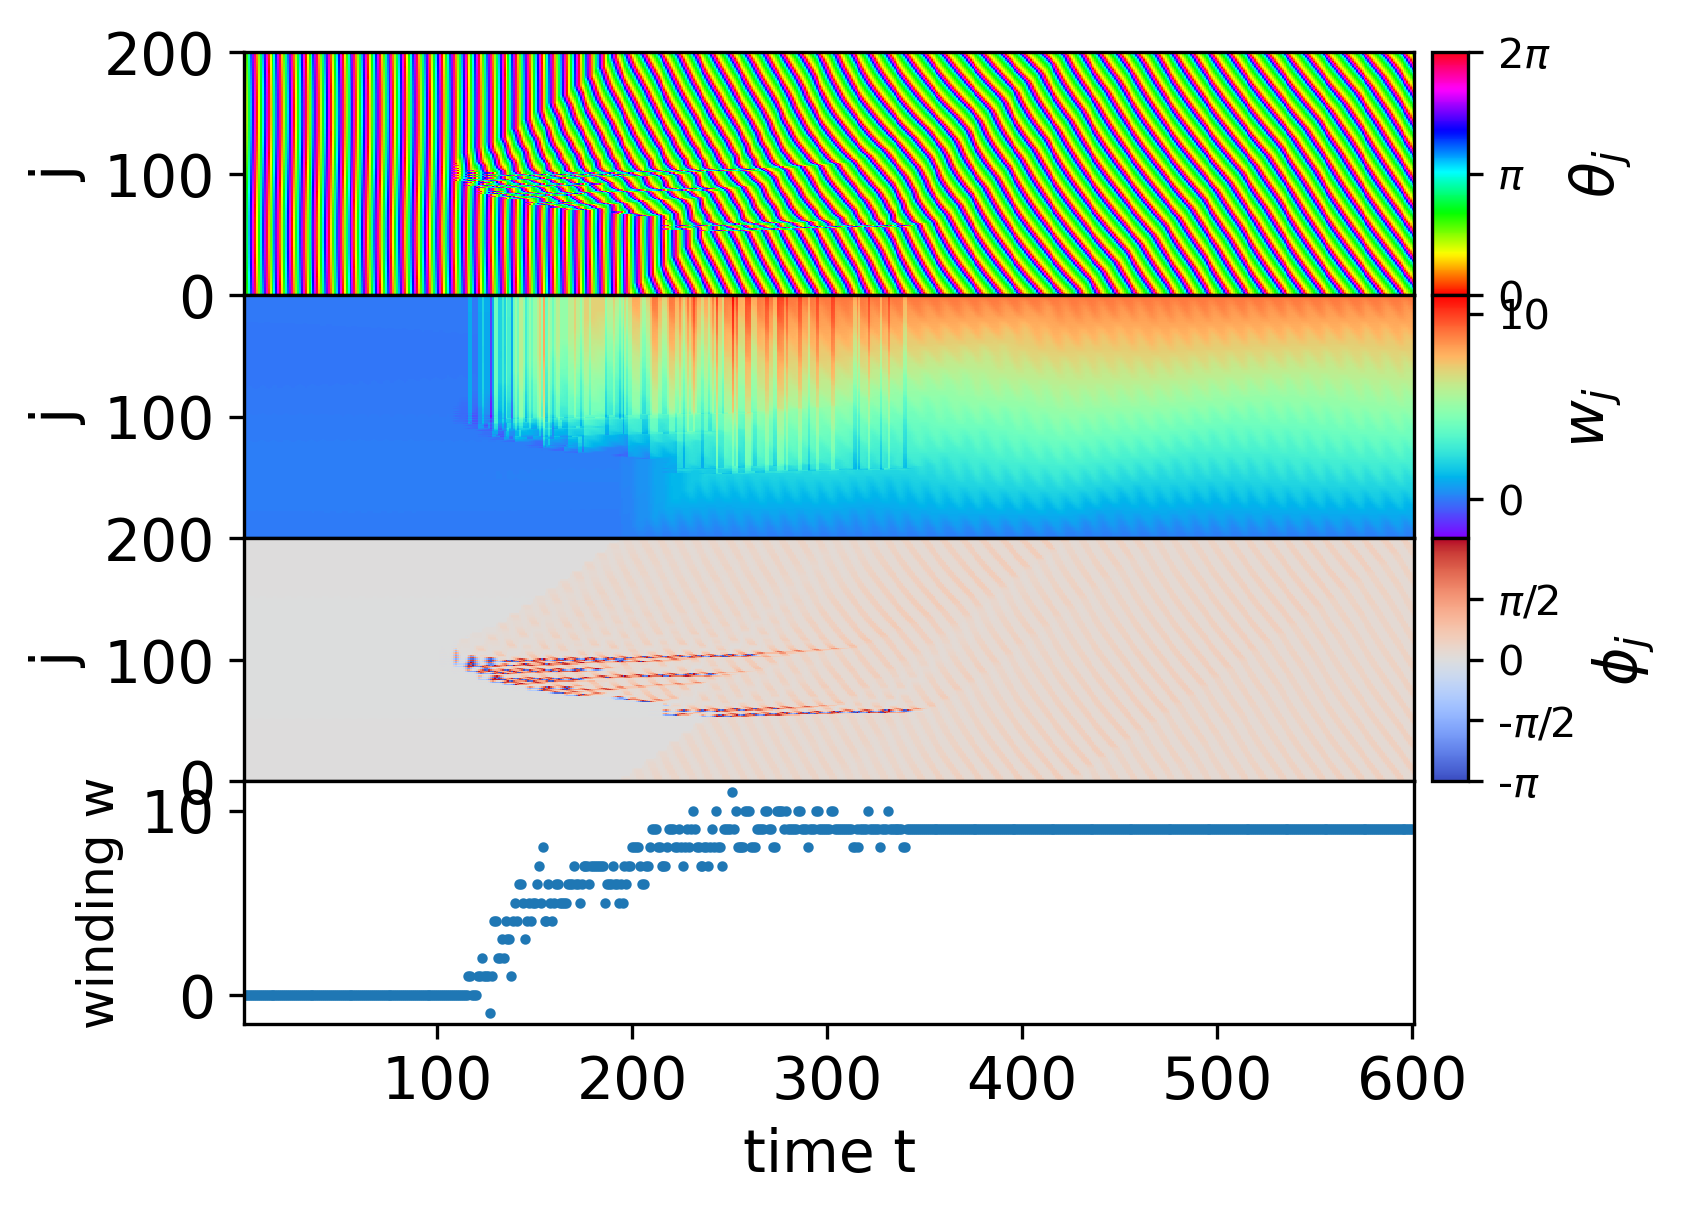

In [79]:
# again the one side overlap model 
K=0.7;  hor=0.05; beta=0.1;  A_c = 0.; A_s = 0.; omega0=1.
nu=0.; nu_c = 0.0
parms = np.zeros(20)
parms[0] = omega0
parms[1] = K
parms[2] = nu
parms[3] = nu_c
parms[4] = beta
parms[5] = hor
parms[6] = A_c
parms[7] = A_s
dt=0.05
func = du_fun_overlap

# initial conditions , single sine
N=200; eta_rand=0.00; slope_ramp = 0; mag_sin = 0.5; index_sin = 1; phase_sin=0
peak =0.0; iroll_ramp=0
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])
u_arr0 = give_init(N,iparms)
plt.plot(u_arr0,'.')

ndn=600; dn=20; nsteps=dn
print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)

ofile="newphase_a_ov1.png"; pos=[-40,200]; alabel=""
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)

time t=1.00
time t=21.00
time t=51.00
time t=91.00
time t=106.00
time t=108.00


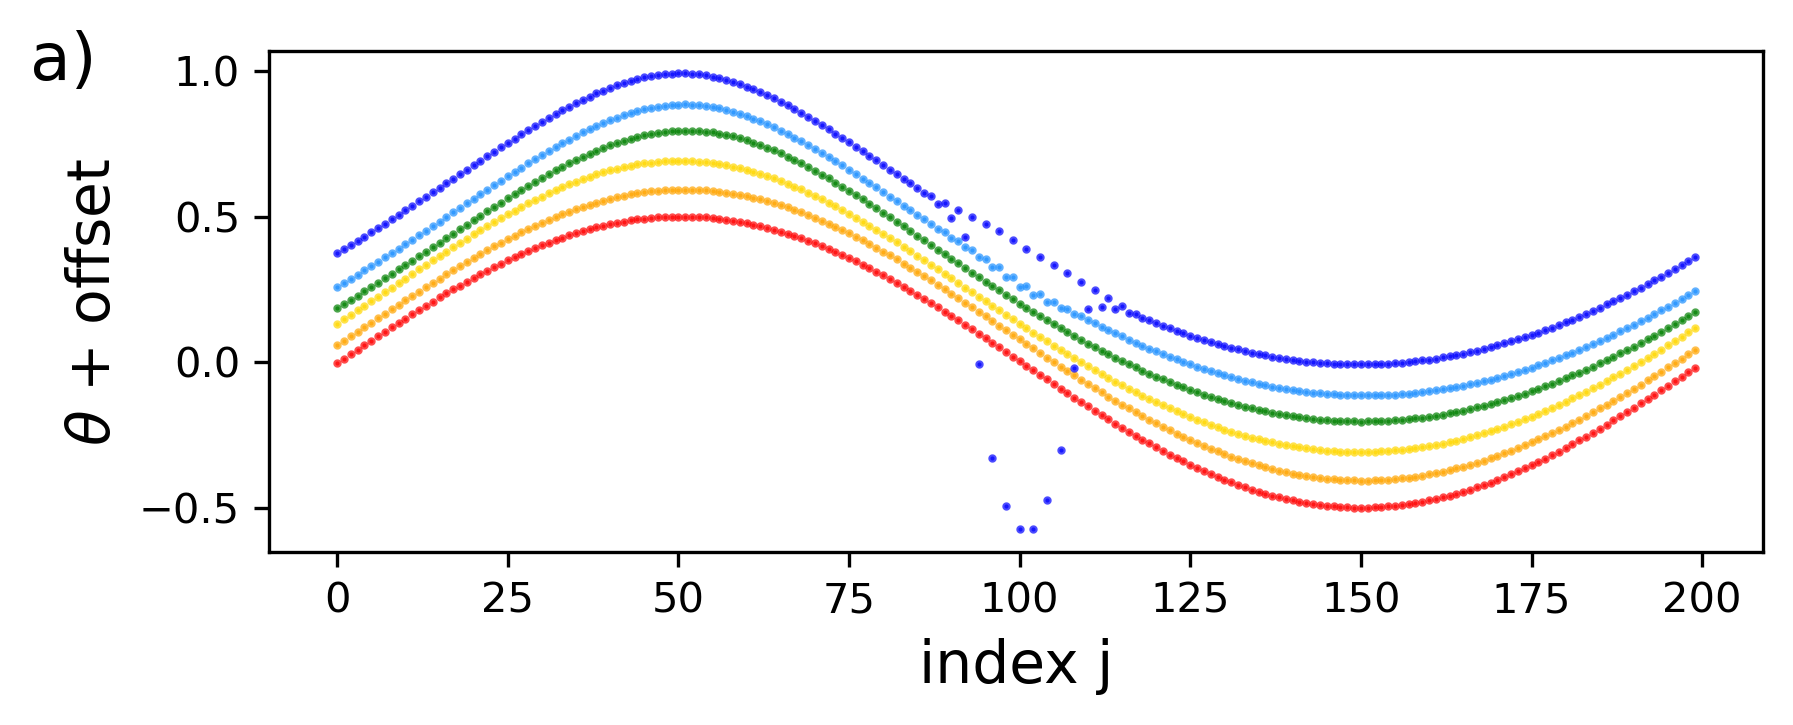

In [82]:
ilist= np.array(range(0,100,10),dtype=int) + 24
ilist = [0,20,50,90,105,107]
offsets = np.zeros(len(ilist))
dz = 0.08
for i in range(len(ilist)):
    offsets[i] = dz*i

ofile = 'sharp_sin_ov1.png'
pos = [-45,0.97]
alabel='a)'
pltlist_mean(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,\
             ilist,offsets,ofile,pos,alabel)

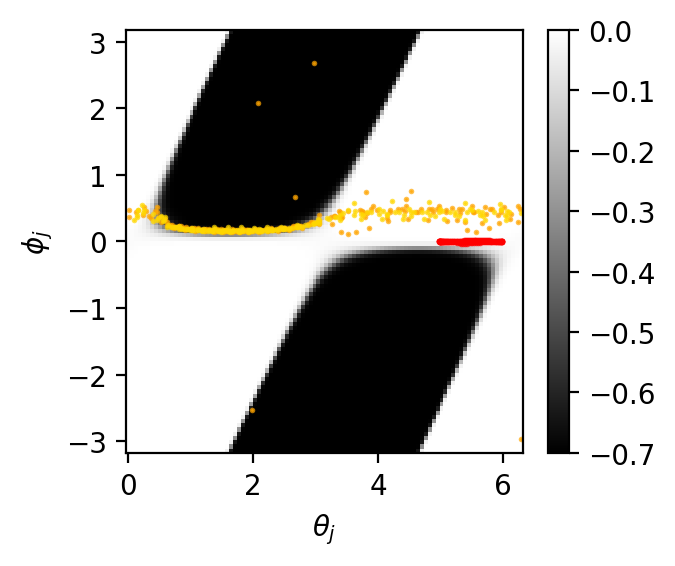

In [419]:
ilist = [100,300,500]
plt_Kfun2(parms,uout_arr,ilist)

t=231.00
t=241.00
t=246.00
t=251.00
t=256.00
t=258.00
t=261.00


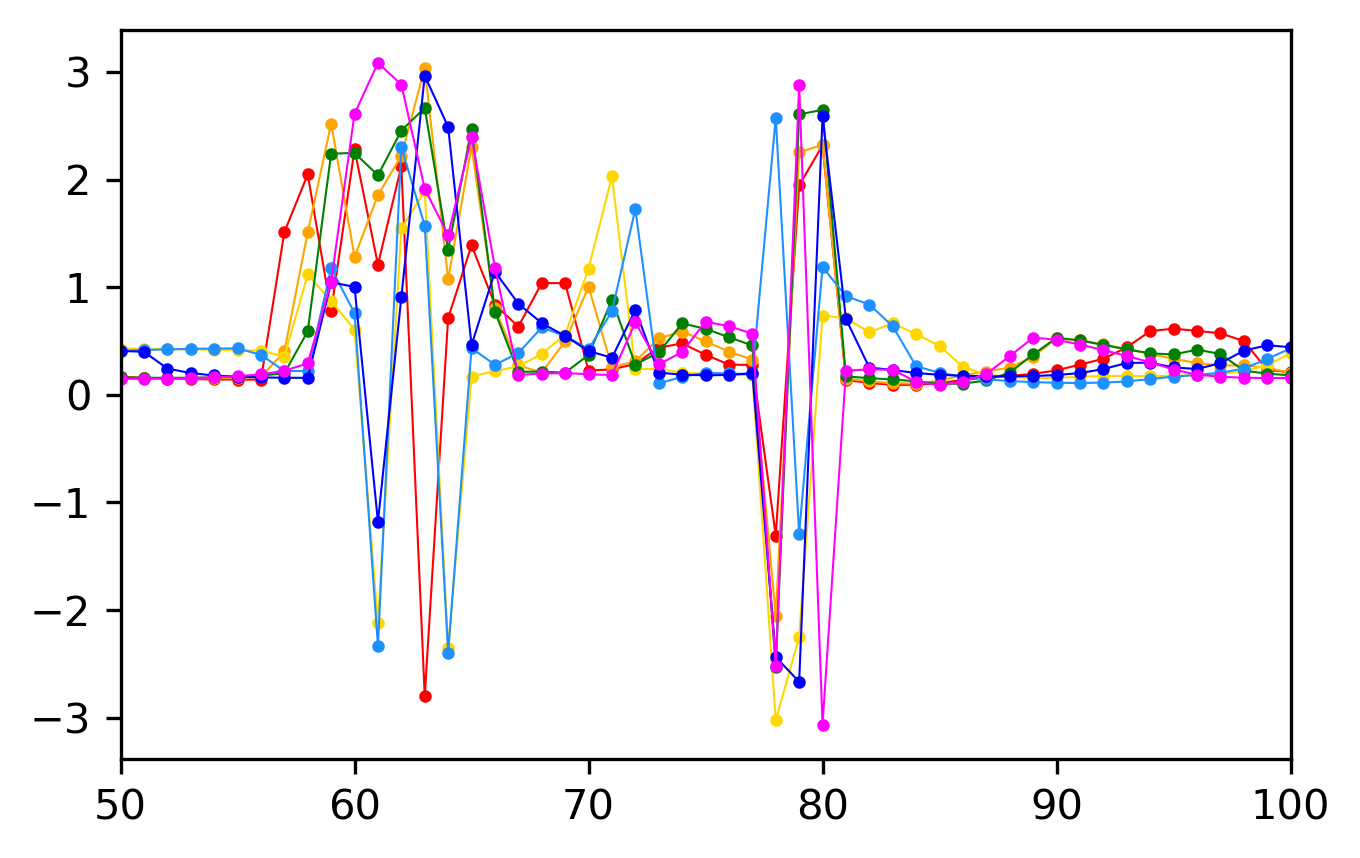

In [416]:
ilist= [230,240,245,250,255,257,260]
pltlist_phi(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ilist,50,100,ofile)

tmax = 601


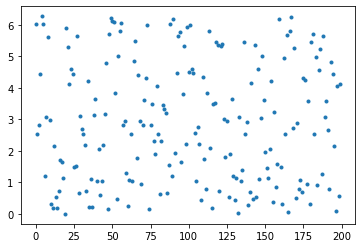

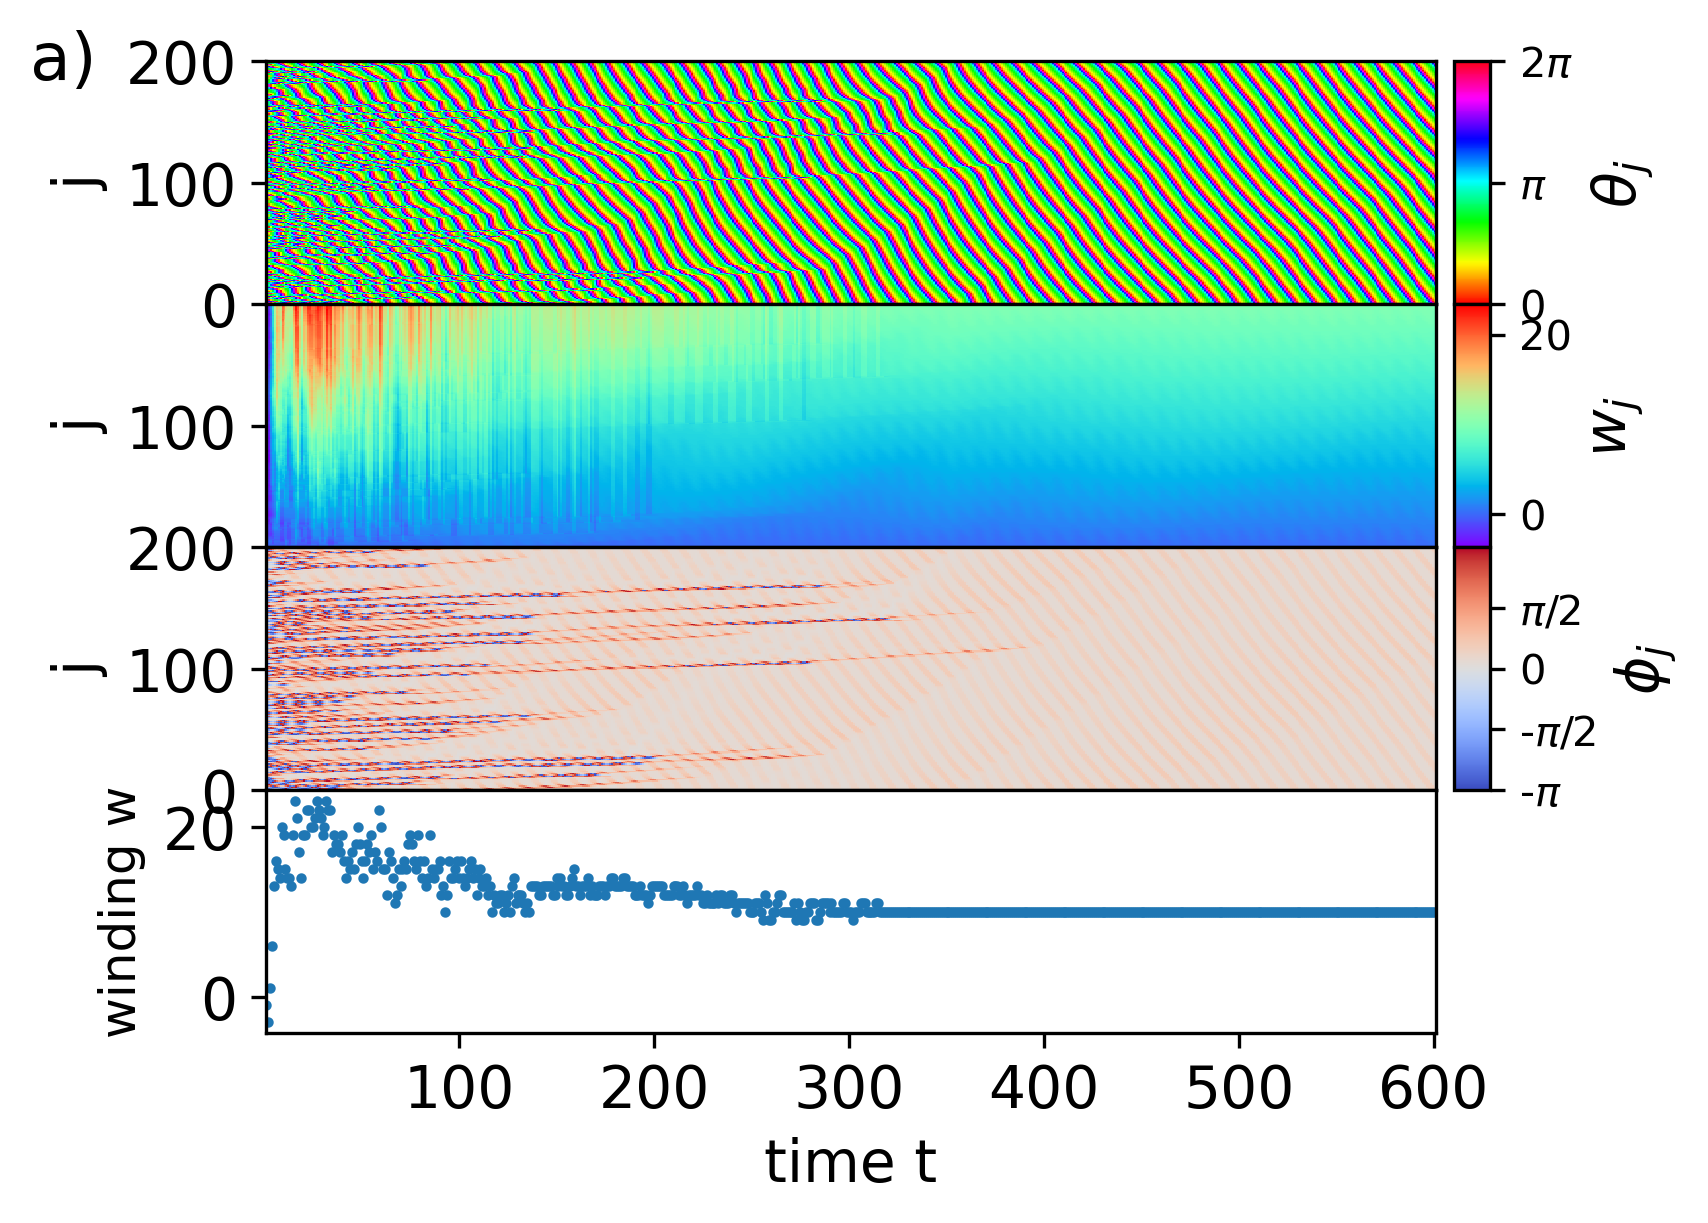

In [88]:
# again the one side overlap model 
K=0.7;  hor=0.05; beta=0.1;  A_c = 0.; A_s = 0.; omega0=1.
nu=0.; nu_c = 0.0
parms = np.zeros(20)
parms[0] = omega0
parms[1] = K
parms[2] = nu
parms[3] = nu_c
parms[4] = beta
parms[5] = hor
parms[6] = A_c
parms[7] = A_s

dt=0.05
func = du_fun_overlap

# initial conditions , rand
N=200; eta_rand=2*np.pi; slope_ramp = 0; mag_sin = 0.0; index_sin = 1; phase_sin=0
peak =0.0; iroll_ramp=0
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])
u_arr0 = give_init(N,iparms)
plt.plot(u_arr0,'.')


ndn=600; dn=20; nsteps=dn
print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)

ofile="newphase_a_ov3.png"; pos=[-120,185]; alabel="a)"
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)

tmax = 240


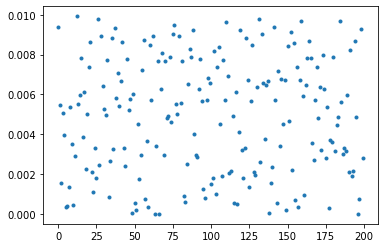

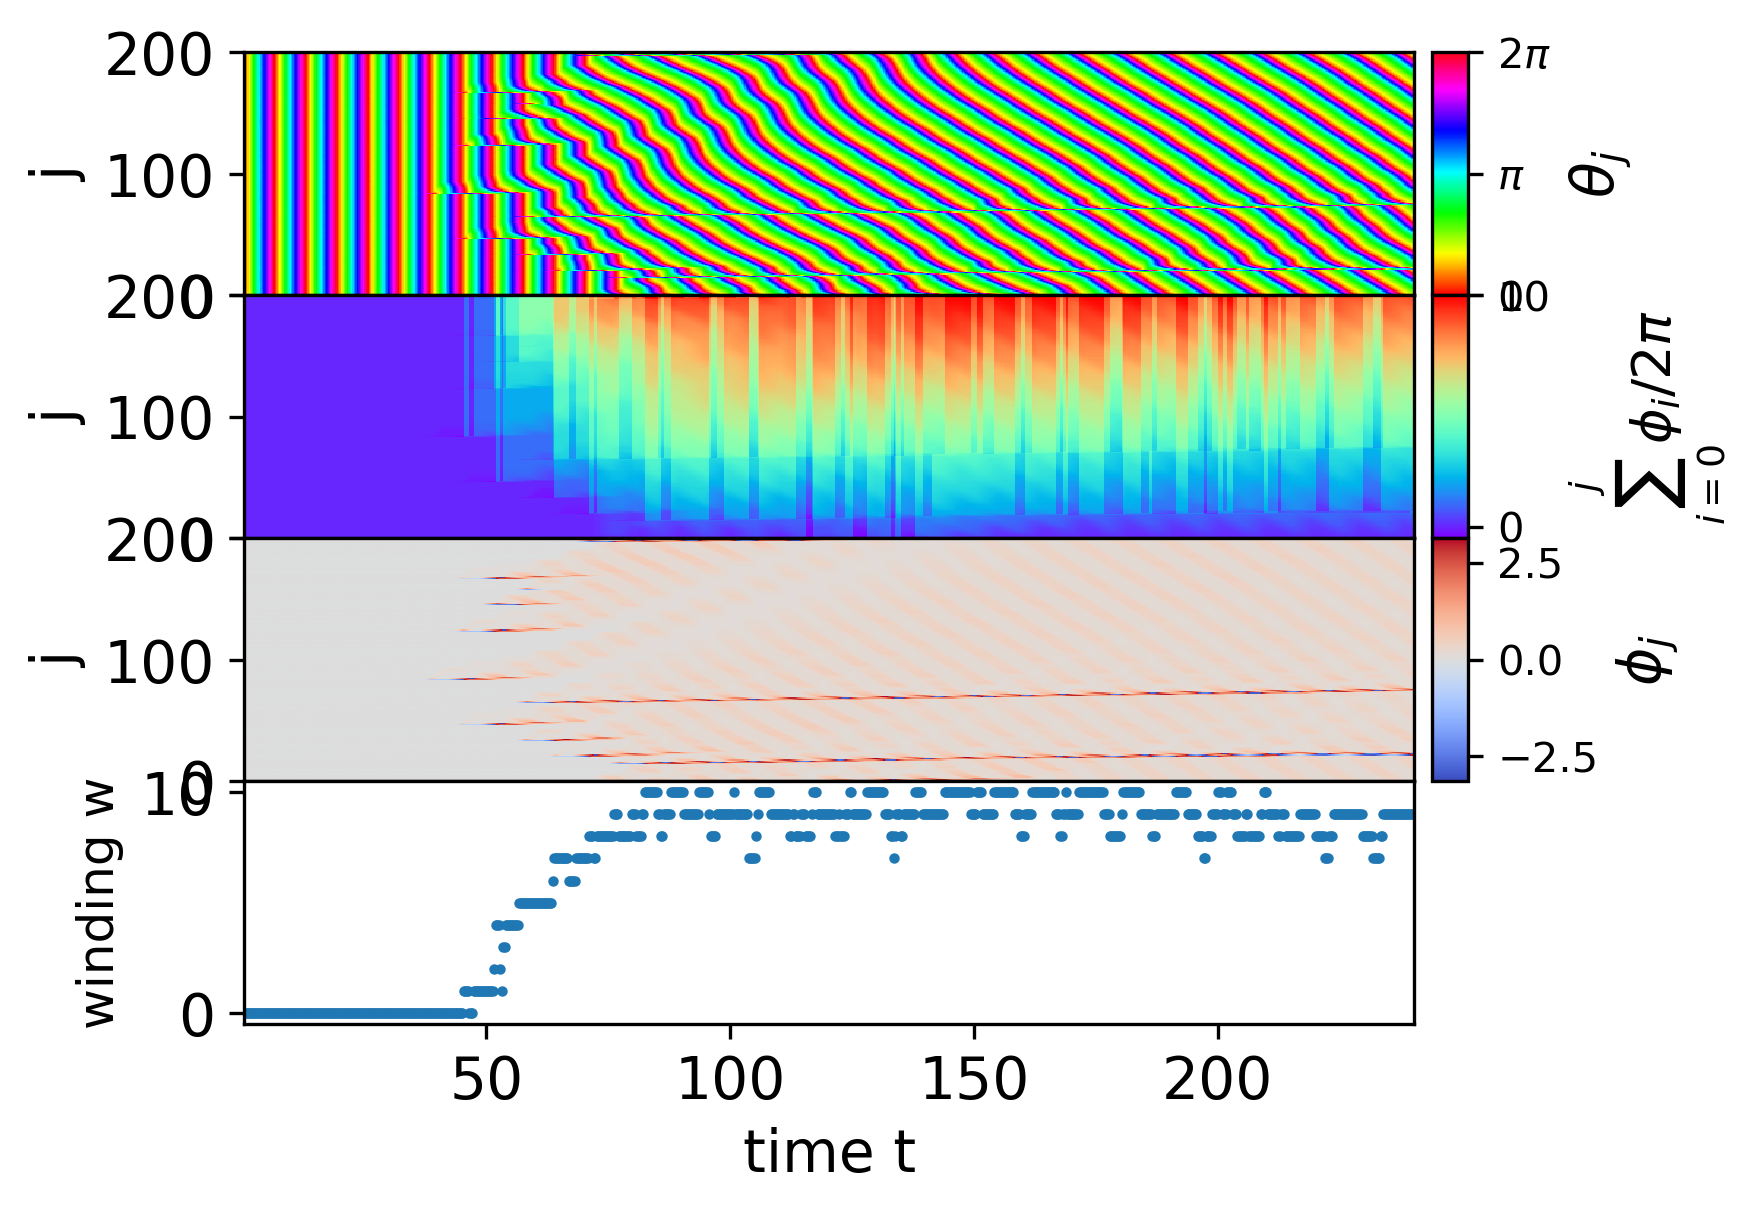

In [33]:
# the one side overlap model 
K=0.7;  hor=0.05; beta=0.1;  A_c = 0.; A_s = 0.; omega0=1.
nu=0.; nu_c = 0.0
parms = np.zeros(20)
parms[0] = omega0
parms[1] = K
parms[2] = nu
parms[3] = nu_c
parms[4] = beta
parms[5] = hor
parms[6] = A_c
parms[7] = A_s

dt=0.05
#print('t0 = {:.1f}, t1={:.1f}'.format(nsteps*dt, (nsteps+dn)*dt))
func = du_fun_overlap

# initial conditions, some small random perturbations on sync state
N=200; eta_rand=0.01; slope_ramp = 0; mag_sin = -0.00; index_sin = 5; phase_sin=0
peak = 0.0; iroll_ramp=0
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])
u_arr0 = give_init(N,iparms)
plt.plot(u_arr0,'.')

ndn=800; dn=6; nsteps=dn
print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)
#ofile=""
#newphase2(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ofile)
ofile=""; pos=[-120,185]; alabel=""
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)

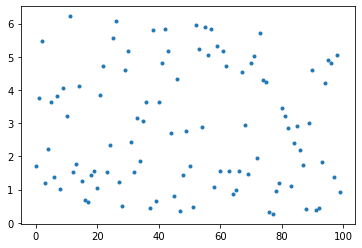

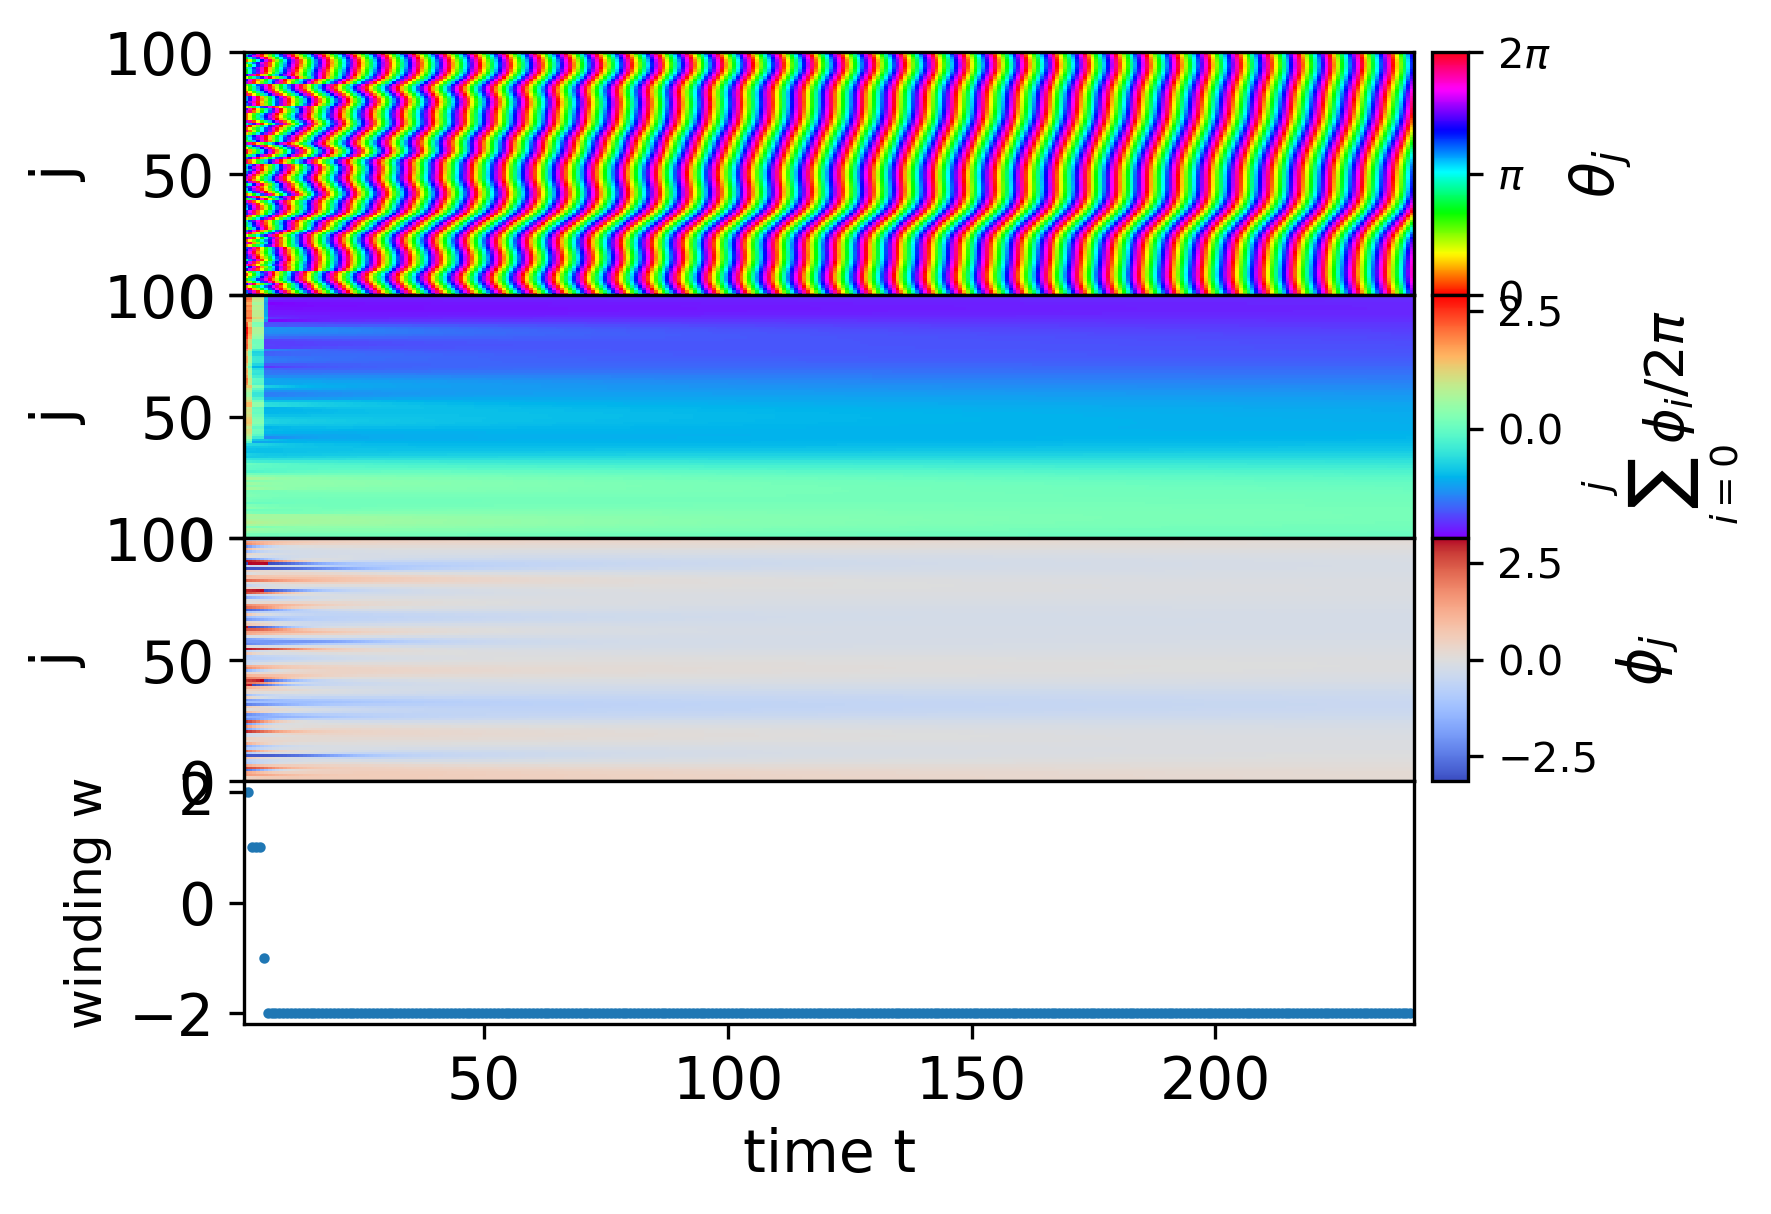

In [34]:
# pure sine interactions (nu)
K=0.0; hor=0.05; beta=0.1; 
A_c = 0.0; A_s = 0.; 
omega0=1.
nu=0.1; nu_c = 0.0
parms = np.zeros(20)
parms[0] = omega0
parms[1] = K
parms[2] = nu
parms[3] = nu_c
parms[4] = beta
parms[5] = hor
parms[6] = A_c
parms[7] = A_s

#nsteps=8000; dn =8000
dt=0.1
func = du_fun_overlap
 
N=100; eta_rand=2*np.pi; slope_ramp = 1.3; mag_sin = 0.0; index_sin = 5; phase_sin=0
peak = 0; iroll_ramp=0
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])
u_arr0 = give_init(N,iparms)
plt.plot(u_arr0,'.')
#plt2(func,u_arr0,parms,dt,nsteps,dn)

ndn=300; dn=8; nsteps=dn
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)
ofile=""; pos=[-120,185]; alabel=""
#newphase2(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ofile)
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)

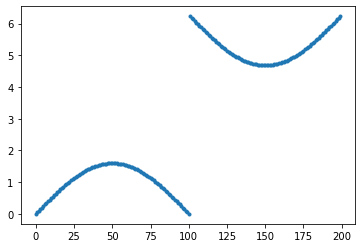

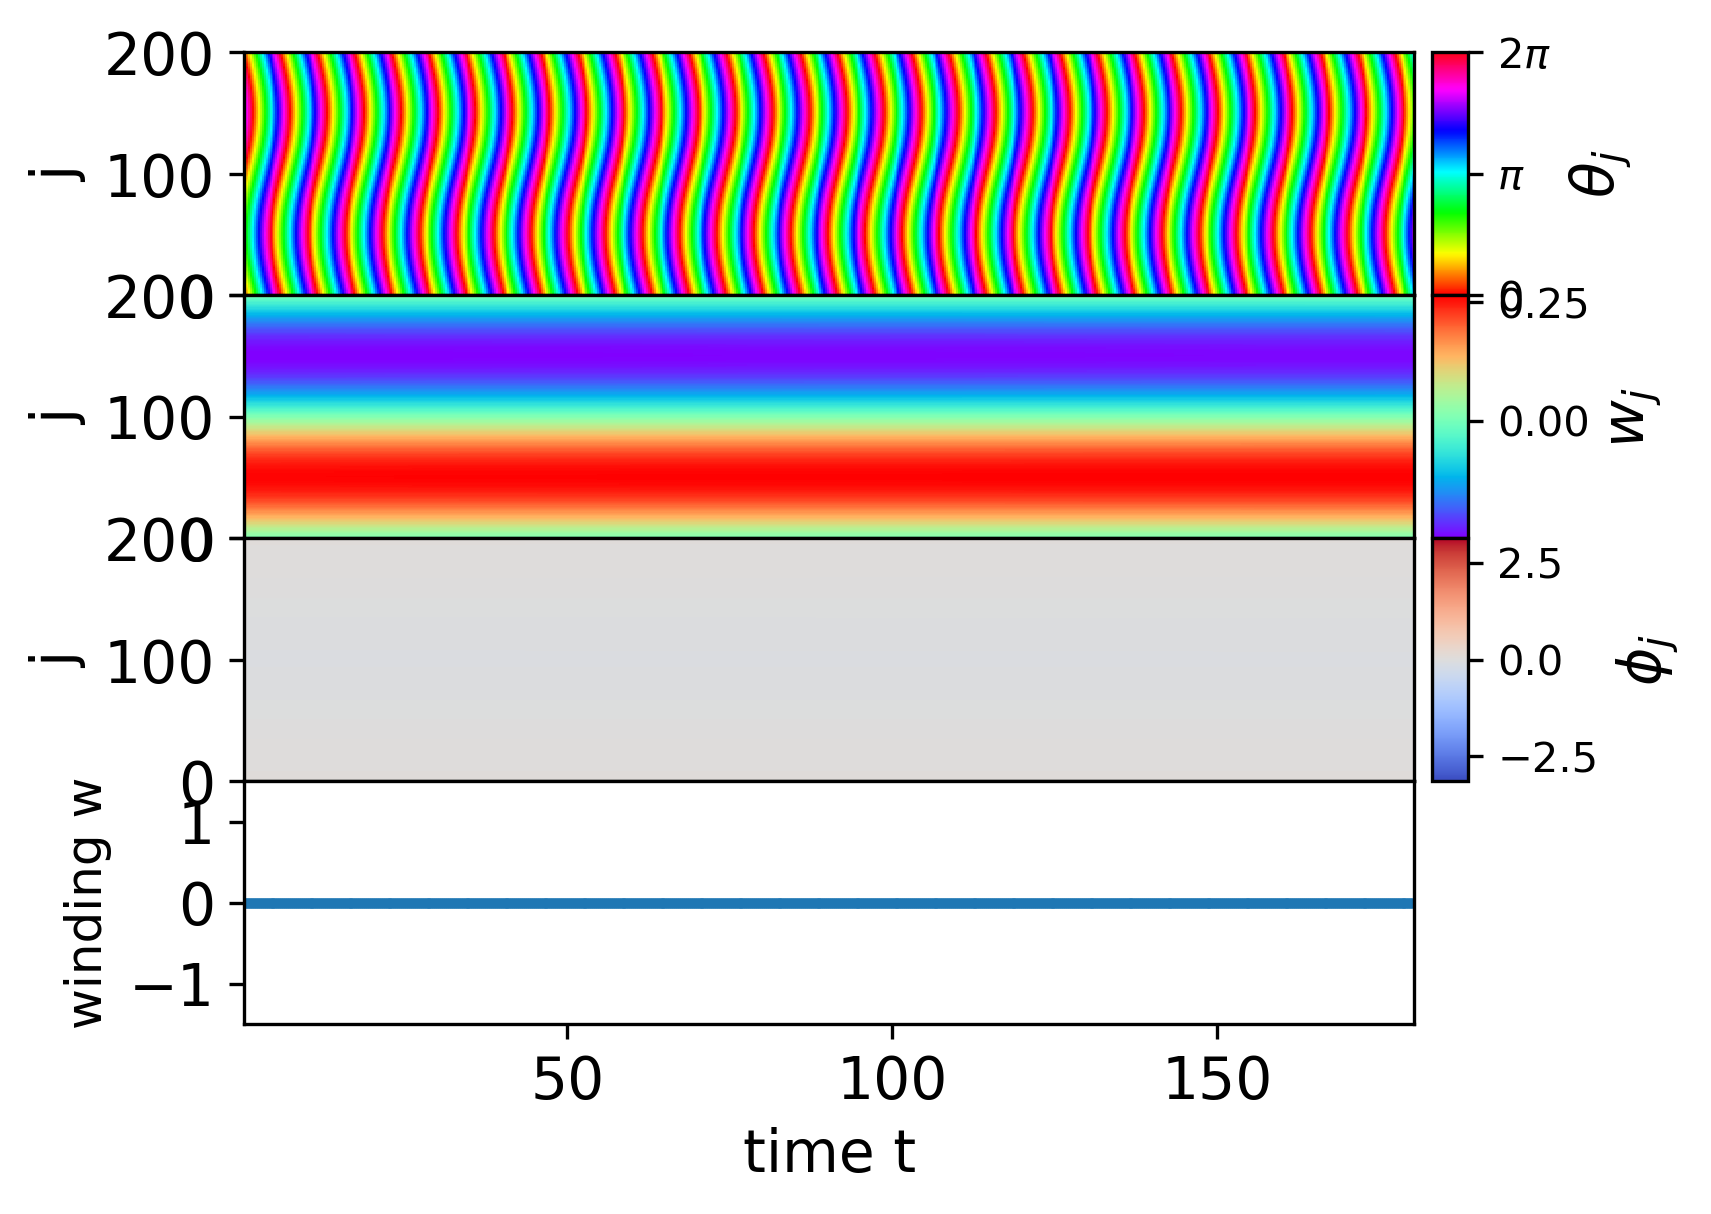

In [52]:
# Niedermayer+08 model?
K=0.0; hor=0.05; beta=0.1; 
A_c = 0.0; A_s = 0.;   
nu =0.03;  nu_c =0.05
#rhomu = 0.1572
#nu = rhomu*0.01;  nu_c = rhomu  # I think this is right? (fig 4 caption of Niedermayer)
# rho mu = 0.1572 and nu is rho mu alpha, alpha =0.01
omega0=1.0
parms = np.zeros(20)
parms[0] = omega0
parms[1] = K
parms[2] = nu
parms[3] = nu_c
parms[4] = beta
parms[5] = hor
parms[6] = A_c
parms[7] = A_s

dt=0.05
func = du_fun_overlap
 
N=200; eta_rand=np.pi*0; slope_ramp = 0.0; mag_sin = 1.6; index_sin = 1; phase_sin=0
peak = 0; iroll_ramp=30
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])
u_arr0 = give_init(N,iparms)
plt.plot(u_arr0,'.')
#plt2(func,u_arr0,parms,dt,nsteps,dn)

ndn=600; dn=6; nsteps=dn
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)
ofile="newphase_a_n1.png"; pos=[-120,185]; alabel=""
#newphase2(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ofile)
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)

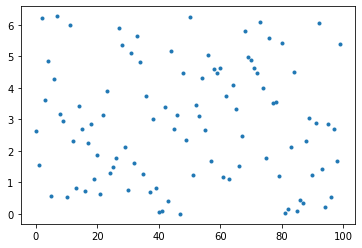

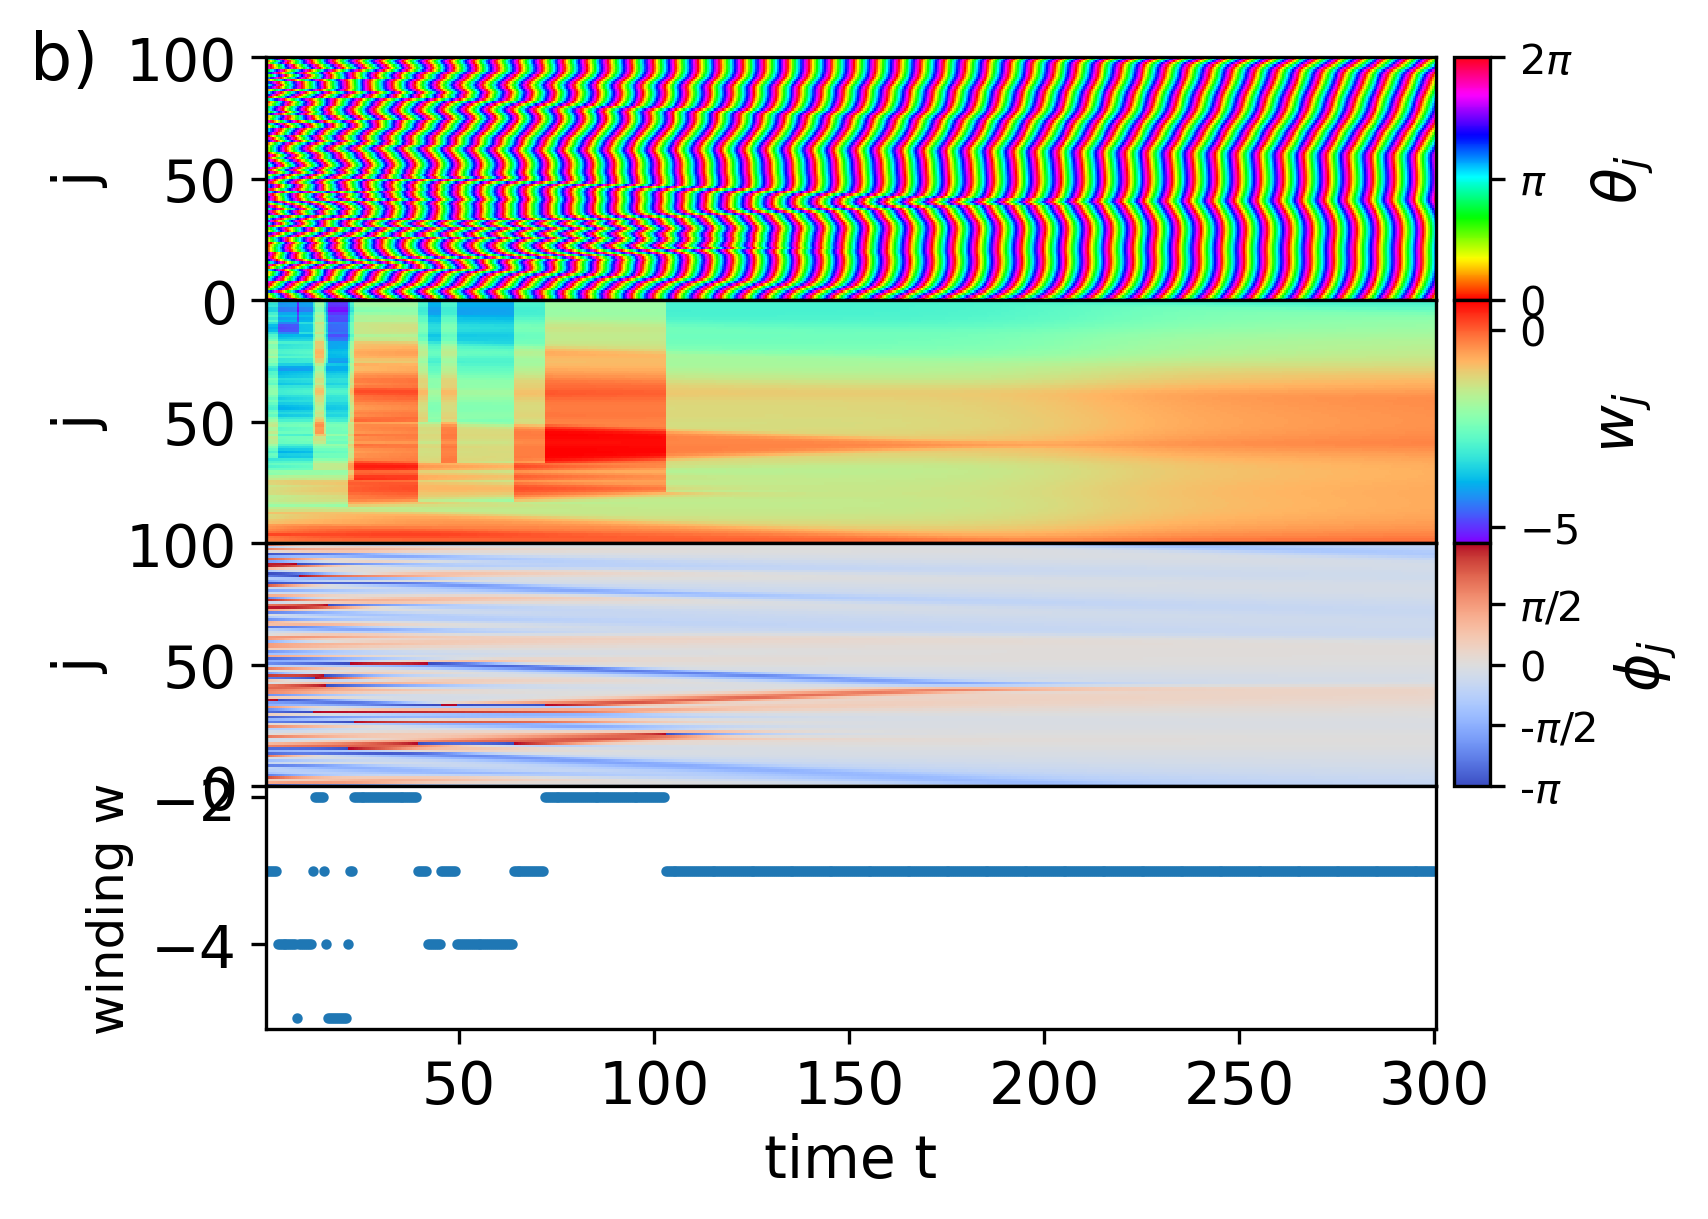

In [95]:
# Niedermayer+08 model
K=0.0; hor=0.05; beta=0.1; 
A_c = 0.0; A_s = 0.;  
nu =0.03;  nu_c =0.05
omega0=1.0
parms = np.zeros(20)
parms[0] = omega0
parms[1] = K
parms[2] = nu
parms[3] = nu_c
parms[4] = beta
parms[5] = hor
parms[6] = A_c
parms[7] = A_s

dt=0.05
func = du_fun_overlap
 
N=100; eta_rand=np.pi*2; slope_ramp = -0.0; mag_sin = 0.0; index_sin = 4; phase_sin=0
peak = 0; iroll_ramp=30
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])
u_arr0 = give_init(N,iparms)
plt.plot(u_arr0,'.')
#plt2(func,u_arr0,parms,dt,nsteps,dn)

ndn=600; dn=10; nsteps=dn
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)
ofile="newphase_a_n3.png"; pos=[-60,91]; alabel="b)"
#newphase2(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ofile)
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)

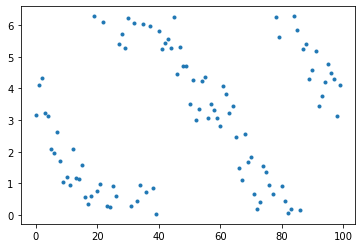

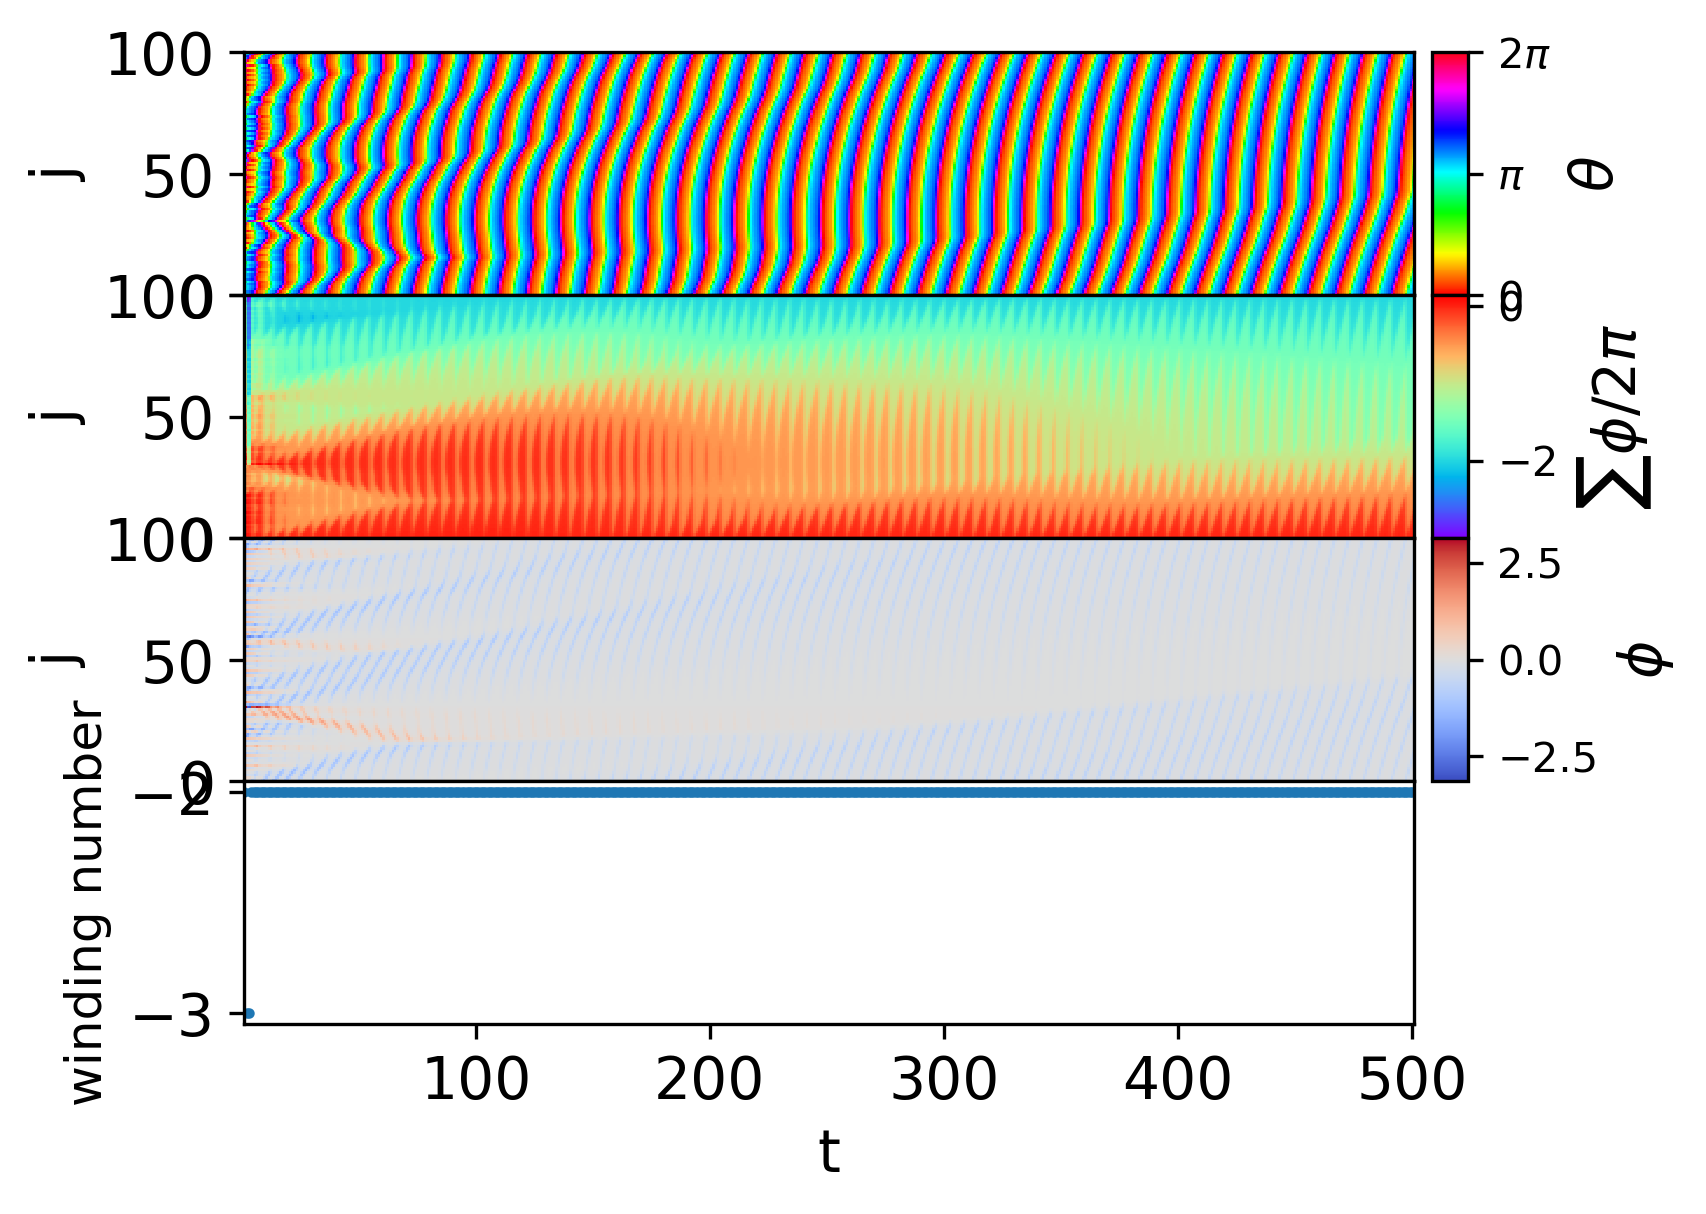

In [481]:
# model with sums of angles 
K=0.0; hor=0.05; beta=0.1; 
A_c = -0.25; A_s = -0.35; 
omega0=1.
nu=0.05;  nu_c= 0.
parms = np.zeros(20)
parms[0] = omega0
parms[1] = K
parms[2] = nu
parms[3] = nu_c
parms[4] = beta
parms[5] = hor
parms[6] = A_c
parms[7] = A_s


dt=0.05
func = du_fun_overlap
 
N=100; eta_rand=2.0; slope_ramp = -2.3; mag_sin = 0.3; index_sin = 5; phase_sin=0
peak = 0; iroll_ramp=30
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])
u_arr0 = give_init(N,iparms)
plt.plot(u_arr0,'.')
#plt2(func,u_arr0,parms,dt,nsteps,dn)

ndn=500; dn=20; nsteps=dn
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)
ofile=""
#newphase2(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ofile)
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,ofile)

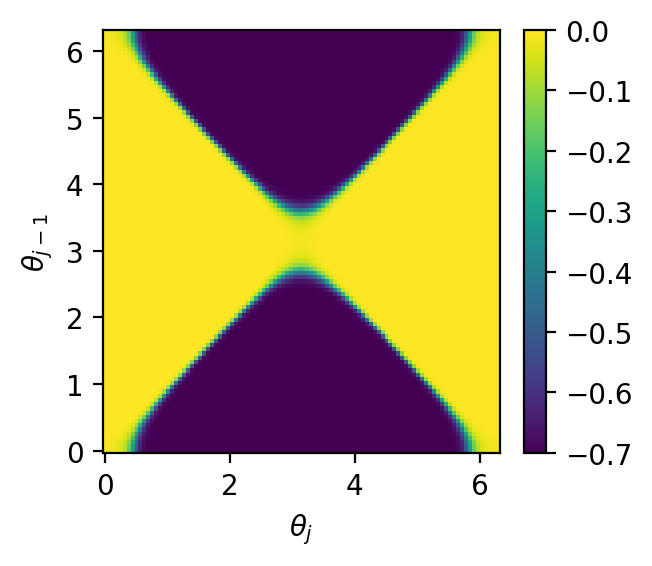

In [335]:


#ujlin = np.linspace(0,2*np.pi,100)
#uplin = np.linspace(0,2*np.pi,100)
#ujmesh,upmesh = np.meshgrid(ujlin,uplin)
#overlap_right = np.cos(ujmesh) - np.cos(upmesh) - beta
#tor = K*0.5*(np.tanh(overlap_right/hor) + 1.)
#fig,ax = plt.subplots(1,1,figsize=(3.2,2.8),dpi=200,facecolor='white')
#im = ax.pcolormesh(ujmesh,upmesh,tor)
#plt.colorbar(im)

In [22]:

# return a list of segments for an angle array
# this is for plotting, so that jumps from 0 to 2pi don't happen
def segments(angle_arr):
    n = len(angle_arr)
    left_i = ()
    right_i = ()
    left_i = np.append(left_i,int(0))
    for i in range(n-1):
        da = np.abs(angle_arr[i+1] - angle_arr[i])
        if (da>np.pi):
            right_i = np.append(right_i,int(i+1))
            left_i = np.append(left_i,int(i+1))
    right_i = np.append(right_i,int(n))
    return left_i, right_i

nn = 30
angle_arr = np.linspace(0,20,nn)%twopi
i_arr = np.arange(0,nn)
left_i, right_i = segments(angle_arr)

# tests
#print(left_i)
#print(right_i)
#for k in range(len(left_i)):
#    li = int(left_i[k]); ri = int(right_i[k])
#    plt.plot(i_arr[li:ri],angle_arr[li:ri],'-')
#plt.plot(i_arr,angle_arr,'o')
